True Vertical Depth Prediction -- Team "Mighty DUC Hunters"
================
* Authors: Anthony Akhigbe, Dapo Awolayo, Lahcene Kahbour, Jeremy Zhao, Adam Elnahas, Christopher Liu, Qian Gao
* Date: August 19th, 2020

### 1. Introduction:
#### 1.1. Background
True vertical depth is the vertical distance from a point (usually the final depth) in the well to a point at the surface and this is one of two primary depth measurements, which is important in determining bottomhole pressures and other subsurface characterizations. Most engineers and geoscientists are required to pass the expected well TVDs to the drillers, which might changes as the wells are drilledd in the field. Under such circumstances, machine learning techniques can be used to predict TVDs to improve subsurface characterization and save time. The goal of this part of the “SPE’s Datathon Contest” is to develop data-driven models by processing various available data from several Wells, and use the data-driven models to predict TVDs in several other Wells within same formation. A robust data-driven model will result in low prediction errors, which is quantified here in terms of Root Mean Squared Error by comparing the predicted and the original TVDs.

We are provided with two major datasets: WellHeader_Datathon.csv (train dataset) and Submission_Sample.csv (test dataset). We built a generalizable data-driven models using train dataset and deployed the newly developed data-driven models on test dataset to predict TVDs. The predicted values were submitted in the same format as Submission_Sample.csv, and submit together with this notebook for reproducibility.

#### 1.2. Data Decription
Files
> #### WellHeader_Datathon.csv It has 87 columns

> #### Submission_Sample.csv A valid sample submission with wells to be predicted and all the features that will be used are in the train dataset

#### 1.3. Evaluation Metric
We are evaluated by the metirc Root Mean Squared Error.

The RMSE is calculated as:

$ ϵ=∑_i \sqrt{ ∑_n (y_p - y_t)^2 /n } $

Where:

$ y_p $ is the predicted TVD
$ y_t $ is the true value for TVD.

### 2. Import:
#### Libraries and Configuration

In [357]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import seaborn as sns
import utm
from geopy.distance import geodesic

# suppress the chained indexing warnings entirely
pd.set_option('mode.chained_assignment',None)

# Fixing random state for reproducibility 
random_seed = 42
np.random.seed(random_seed)

#### Input data

In [388]:
wellheader = pd.read_csv('D:/.jupyter/Data_Competition/WellHeader_Datathon.csv')
TVDtest = pd.read_csv('D:/.jupyter/Data_Competition/Submission_Sample.csv')

#drop unamed column

def mod_data(df):
    if ('Unnamed: 0' in df.columns):
        df=df.drop('Unnamed: 0',axis=1)
    df.columns = (df.columns
                  .str.replace(".","_")
                  .str.replace("`","_")
                  .str.replace(" ","_")
                  .str.replace(":","")
                 )
    return df

wellheader=mod_data(wellheader)
wellheader.set_index('EPAssetsId',inplace=True)
wellheader.columns

Index(['Province', 'LicenceNumber', 'UWI', 'CurrentOperator',
       'CurrentOperatorParent', 'CurrentOperatorParentName', 'Licensee',
       'LicenseeParentCompany', 'LicenseeParentCompanyName', 'LicenceDate',
       'CurrentStatus', 'CurrentStatusStandardised', 'WellType',
       'WellTypeStandardised', 'ConfidentialReleaseDate', 'AbandonDate',
       'SurfAbandonDate', 'WellName', 'Formation', 'Field', 'Pool',
       'SurveySystem', 'Surf_Location', 'Surf_Township', 'Surf_Meridian',
       'Surf_Range', 'Surf_Section', 'Surf_LSD', 'Surf_Longitude',
       'Surf_Latitude', 'Surf_TownshipRange', 'Surf_QuarterUnit', 'Surf_Unit',
       'Surf_Block', 'Surf_NTSMapSheet', 'Surf_Series', 'Surf_Area',
       'Surf_Sheet', 'Surf_QuarterSection', 'BH_Location', 'BH_TownshipRange',
       'BH_QuarterUnit', 'BH_Unit', 'BH_Block', 'BH_NTSMapSheet', 'BH_Series',
       'BH_Area', 'BH_Sheet', 'BH_QuarterSection', 'BH_Longitude',
       'BH_Latitude', 'BH_Township', 'BH_Meridian', 'BH_Range', 'BH_S

In [359]:
#Plotting function
def plot_scatter(x, y, **kwargs):
    size=kwargs.setdefault('size',4)
    marker=kwargs.setdefault('marker','o')
    label=kwargs.setdefault('label','')
    x_label=kwargs.setdefault('x_label','')
    y_label=kwargs.setdefault('y_label','')
    title=kwargs.setdefault('title','')
    plt.scatter(x, y, marker=marker, s=size, label=label)
    plt.ylim(y.min(), y.max())
    plt.gca().invert_yaxis()
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()  
    
def plot_result(Y_test, Y_pred, r2, rmse, name):
    fig = plt.figure(figsize=(10.0, 10.0))
    plot_scatter(Y_test, Y_pred, x_label='Real TVD', y_label='Predicted TVD')
    lims = [np.min([plt.gca().get_xlim(), plt.gca().get_ylim()]),
            np.max([plt.gca().get_xlim(), plt.gca().get_ylim()]),  # max of both axes
           ]    
    # now plot both limits against eachother
    plt.plot(lims, lims, 'r--', alpha=0.75, zorder=0)
    plt.gca().set_xlim(lims)
    plt.gca().set_ylim(lims)
    fig.suptitle('Formation {:s} test data R2 = {:.3f} and RMSE = {:.5f}'.format(name,r2, rmse), weight='bold', fontsize=15)

### 3. Data Visualization, Preprocessing and Model Construction:

#### Exploratory Data Analysis
EDA is an open-ended process where we calculate statistics and make figures to find trends, missing values, outliers, anomalies, patterns, or relationships within the data.

In [367]:
#convert object appearing as values to numerical values
col=['Surf_Township', 'Surf_Range', 'Surf_Section', 'Surf_LSD',
     'BH_Section', 'BH_LSD', 'BH_Township', 'BH_Range']
for column in col:
    wellheader[column]=pd.to_numeric(wellheader[column], errors='coerce')

#Features selected 
welldata = wellheader[['CurrentOperatorParent', 'WellTypeStandardised', 'Formation', 
                       'WellProfile', 'PSACAreaName', 'LaheeClass', 'TotalDepth', 'GroundElevation',
                       'KBElevation', 'Surf_Latitude', 'Surf_Longitude', 'BH_Latitude',
                       'BH_Longitude', 'TVD']].copy()

# converting LAT/Long To XY and calculate Euclidean distance 
for index in welldata.index:
    welldata.loc[index,'Surf_UTMX'],welldata.loc[index,'Surf_UTMY'],_,_=utm.from_latlon(welldata.loc[index,'Surf_Latitude'], 
                                                                        welldata.loc[index,'Surf_Longitude']) 
    if np.isnan(welldata.loc[index,'BH_Latitude']):
        welldata.loc[index,'BH_UTMX']=np.nan; welldata.loc[index,'BH_UTMY']=np.nan
    else:
        welldata.loc[index,'BH_UTMX'],welldata.loc[index,'BH_UTMY'],_,_=utm.from_latlon(welldata.loc[index,'BH_Latitude'], 
                                                                        welldata.loc[index,'BH_Longitude']) 
    Surf = (welldata.loc[index,'Surf_Latitude'], welldata.loc[index,'Surf_Longitude'])
    BH = (welldata.loc[index,'BH_Latitude'], welldata.loc[index,'BH_Longitude'])
    if np.isnan(welldata.loc[index,'BH_Latitude']):
        welldata.loc[index,'Distance']=np.nan
    else:
        welldata.loc[index,'Distance']=geodesic(Surf, BH).m

welldata["Diff_Elevation"] = welldata['KBElevation'] - welldata['GroundElevation']

#group the test data and features
df_blind = welldata.loc[TVDtest.EPAssetsId] 

#drop missing values
welldata.dropna(inplace=True)
print(welldata.info())

#classify columns as categorical and numerical
CategoricalColumns = welldata.select_dtypes(include=[np.object]).columns
NumericalColumns = welldata.select_dtypes(include=[np.float, np.int, np.int64]).columns

#more data cleaning
for col in CategoricalColumns:
    welldata[col]=welldata[col].apply(lambda x: x.replace(" ","_").replace("-","_"))

welldata.columns

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6731 entries, 2593278 to 2613169
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CurrentOperatorParent  6731 non-null   int64  
 1   WellTypeStandardised   6731 non-null   object 
 2   Formation              6731 non-null   object 
 3   WellProfile            6731 non-null   object 
 4   PSACAreaName           6731 non-null   object 
 5   LaheeClass             6731 non-null   object 
 6   TotalDepth             6731 non-null   float64
 7   GroundElevation        6731 non-null   float64
 8   KBElevation            6731 non-null   float64
 9   Surf_Latitude          6731 non-null   float64
 10  Surf_Longitude         6731 non-null   float64
 11  BH_Latitude            6731 non-null   float64
 12  BH_Longitude           6731 non-null   float64
 13  TVD                    6731 non-null   float64
 14  Surf_UTMX              6731 non-null   float64


Index(['CurrentOperatorParent', 'WellTypeStandardised', 'Formation',
       'WellProfile', 'PSACAreaName', 'LaheeClass', 'TotalDepth',
       'GroundElevation', 'KBElevation', 'Surf_Latitude', 'Surf_Longitude',
       'BH_Latitude', 'BH_Longitude', 'TVD', 'Surf_UTMX', 'Surf_UTMY',
       'BH_UTMX', 'BH_UTMY', 'Distance', 'Diff_Elevation'],
      dtype='object')

#### Feature Engineering

,feature importance
CurrentOperatorParent,0.003111
BH_UTMY,0.003204
Diff_Elevation,0.003255
BH_Latitude,0.003267
Surf_UTMY,0.004983
GroundElevation,0.005949
Surf_Latitude,0.007768
BH_UTMX,0.008870
Surf_UTMX,0.008984
BH_Longitude,0.011276


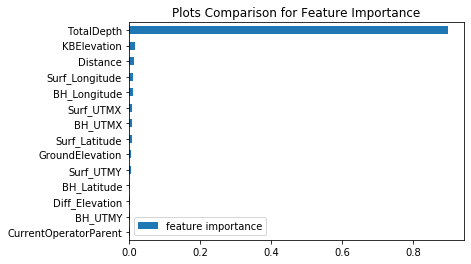

In [390]:
#convert categorical columns with labeler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
def label_cat(X,CategoricalColumns):
    lab=[]
    labdict={}
    for index, value in enumerate(CategoricalColumns):
        lab.append('labeler_%s' % value)
        labdict[lab[index]] = LabelEncoder()
        X[value]=labdict[lab[index]].fit_transform(X[value])
    return X, labdict
df, labdict=label_cat(welldata.copy(),CategoricalColumns)
df_labels=df['TVD']
df_features = df[NumericalColumns].drop(['TVD'], axis=1)

from sklearn.ensemble import RandomForestRegressor
reg = RandomForestRegressor(n_estimators=1000)
reg.fit(df_features, df_labels)
df_feature_importance = DataFrame(reg.feature_importances_, 
                                  index=df_features.columns, 
                                  columns=['feature importance']).sort_values('feature importance', ascending=True)
df_feature_importance.plot(kind='barh', title='Plots Comparison for Feature Importance')
df_feature_importance

#### Check for Collinear Variables

Collinear variables are those which are highly correlated with one another and have tendency to decrease the model's availablility to learn and interpret, and decrease generalization performance on the test set. An arbitrary threshold was established on the absolute magnitude of the Pearson correlation coefficient greater than 0.95 for removing collinear variables.

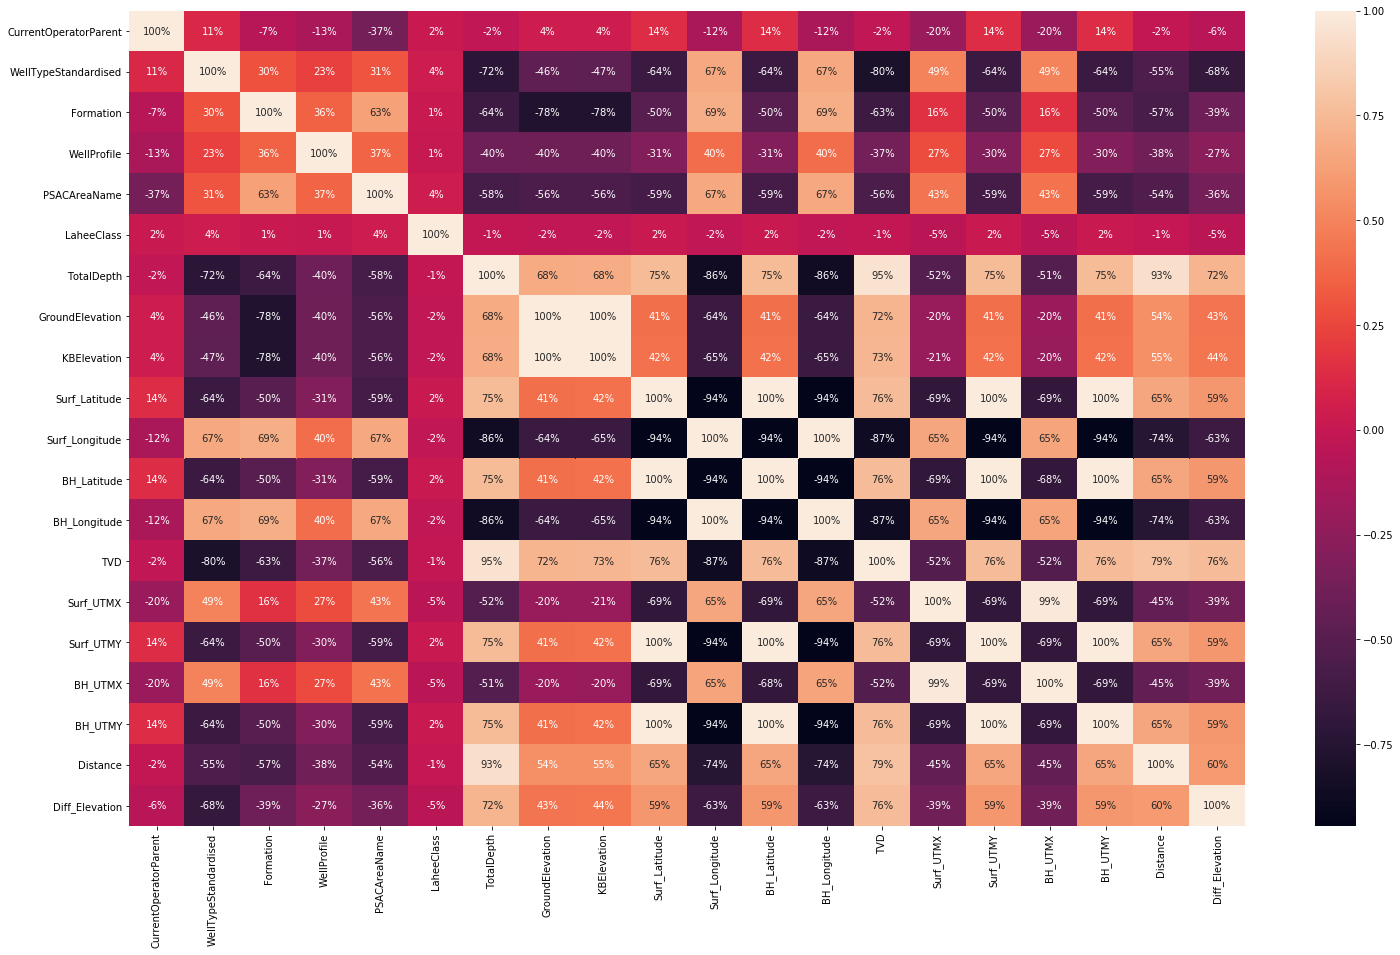

In [369]:
# Visualize correlation between datasets
plt.figure(figsize= (25,15)) #adjust size to fit plots (width, height)
sns.heatmap(df.corr(), annot=True, fmt ='.0%')

In [370]:
# Threshold for removing correlated variables
threshold = 0.95

# Absolute value correlation matrix
corr_matrix = df_features.corr().abs()
corr_matrix.head()


# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
display(upper)#.head()

# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns that are highly correlated with one another and need to be removed.' % (len(to_drop)))
display(to_drop)
#welldata = welldata.drop(columns = to_drop)
#df_blind = df_blind.drop(columns = to_drop)
#display(welldata)

,CurrentOperatorParent,TotalDepth,GroundElevation,KBElevation,Surf_Latitude,Surf_Longitude,BH_Latitude,BH_Longitude,Surf_UTMX,Surf_UTMY,BH_UTMX,BH_UTMY,Distance,Diff_Elevation
CurrentOperatorParent,NaN,0.024288,0.040229,0.039323,0.140604,0.123493,0.140788,0.123603,0.199341,0.139513,0.197702,0.139701,0.016916,0.061716
TotalDepth,NaN,NaN,0.676221,0.681092,0.754513,0.859214,0.754516,0.859176,0.518511,0.754484,0.514751,0.754486,0.933398,0.723718
GroundElevation,NaN,NaN,NaN,0.999947,0.411832,0.643847,0.411976,0.643849,0.201851,0.410646,0.197691,0.410791,0.544675,0.434824
KBElevation,NaN,NaN,NaN,NaN,0.416483,0.647808,0.416626,0.647809,0.205261,0.415296,0.201106,0.415440,0.548779,0.444060
Surf_Latitude,NaN,NaN,NaN,NaN,NaN,0.944693,0.999960,0.944688,0.690237,0.999976,0.685083,0.999938,0.654514,0.588333
Surf_Longitude,NaN,NaN,NaN,NaN,NaN,NaN,0.944623,0.999989,0.653884,0.944513,0.648600,0.944445,0.741094,0.629838
BH_Latitude,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.944631,0.690015,0.999932,0.684883,0.999976,0.654503,0.588323
BH_Longitude,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.653899,0.944507,0.648629,0.944451,0.741011,0.629766
Surf_UTMX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.690725,0.985829,0.690501,0.450713,0.387364
Surf_UTMY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.685623,0.999959,0.654920,0.587637


There are 6 columns that are highly correlated with one another and need to be removed.


['KBElevation',
 'BH_Latitude',
 'BH_Longitude',
 'Surf_UTMY',
 'BH_UTMX',
 'BH_UTMY']

In [373]:
#Remove TVD Less Than KB Elevation Filter
df_train=welldata[welldata['KBElevation']<welldata['TVD']]
df_train.describe()

,CurrentOperatorParent,TotalDepth,GroundElevation,KBElevation,Surf_Latitude,Surf_Longitude,BH_Latitude,BH_Longitude,TVD,Surf_UTMX,Surf_UTMY,BH_UTMX,BH_UTMY,Distance,Diff_Elevation
count,6233.000000,6233.00000,6233.000000,6233.000000,6233.000000,6233.000000,6233.000000,6233.000000,6233.000000,6233.000000,6.233000e+03,6233.000000,6.233000e+03,6233.000000,6233.000000
mean,2225.480667,3130.07228,795.025509,800.024364,52.736500,-112.912892,52.736991,-112.912654,1478.635286,542255.777649,5.844601e+06,541800.175253,5.844656e+06,1726.707203,4.998854
std,2946.945024,1673.62901,138.644717,139.329485,1.434120,4.075904,1.434775,4.075812,924.341532,118964.229075,1.592520e+05,119132.115345,1.593240e+05,830.953043,1.609688
min,16.000000,892.00000,565.200000,569.800000,49.961725,-119.972137,49.964650,-119.999593,575.440000,289933.455386,5.537941e+06,289893.788725,5.538294e+06,0.000000,-1.400000
25%,247.000000,1578.00000,694.800000,699.000000,51.556633,-116.976521,51.555892,-116.978636,718.340000,463368.512971,5.713645e+06,462606.000632,5.713592e+06,942.348034,4.200000
50%,1237.000000,2337.00000,730.500000,735.700000,51.980196,-111.178334,51.981388,-111.175960,887.200000,595412.078721,5.758950e+06,594738.443433,5.759240e+06,1605.543865,4.300000
75%,1998.000000,4567.00000,884.500000,891.400000,54.269498,-109.012482,54.268173,-109.010221,2271.250000,642385.400358,6.013952e+06,642391.146324,6.013366e+06,2354.337748,5.600000
max,9901.000000,7848.00000,1371.100000,1377.000000,56.594819,-107.746019,56.580394,-107.726882,4366.000000,710176.767071,6.273852e+06,710030.244269,6.272218e+06,5454.628079,12.000000


<Figure size 1080x1080 with 0 Axes>

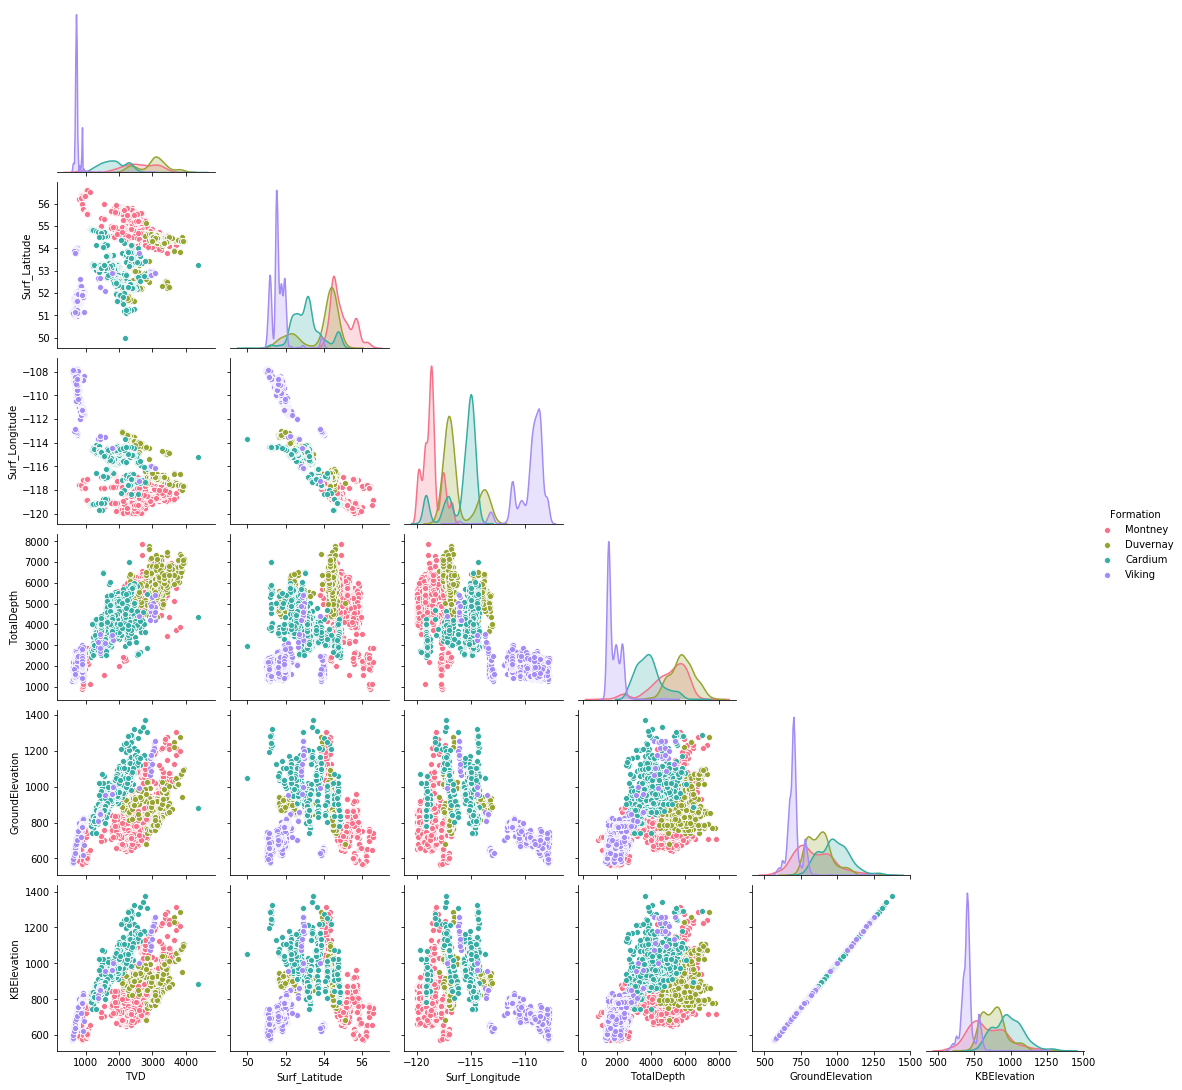

In [372]:
#training data
plt.figure(figsize= (15,15))
ax=sns.pairplot(df_train, vars=['TVD', 'Surf_Latitude', 'Surf_Longitude', 'TotalDepth', 'GroundElevation', 'KBElevation'], 
                kind='scatter', diag_kind='kde', hue='Formation', palette='husl', height=2.5, corner=True)

<Figure size 1080x1080 with 0 Axes>

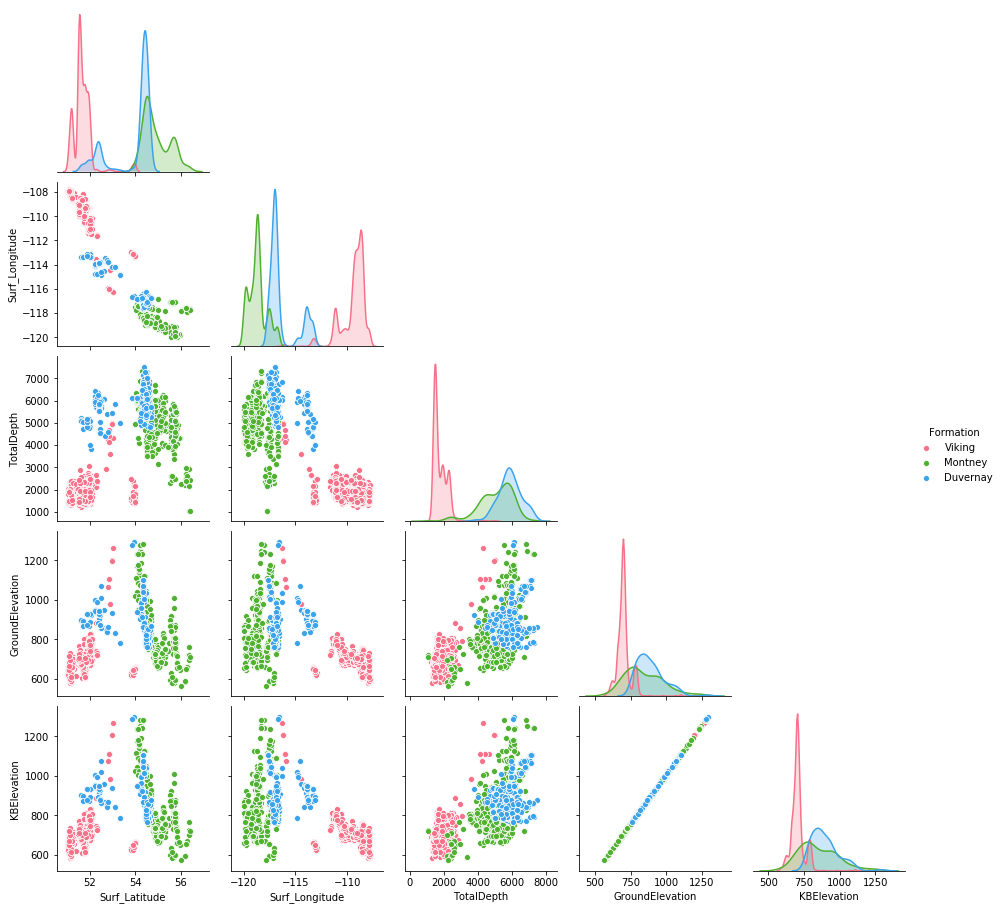

In [81]:
#test data
plt.figure(figsize= (15,15))
ax=sns.pairplot(df_blind, vars=['Surf_Latitude','Surf_Longitude', 'TotalDepth', 'GroundElevation', 'KBElevation'], 
                kind='scatter', diag_kind='kde', hue='Formation', palette='husl', height=2.5, corner=True)

#### Build Machine Learning Models

In [374]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.model_selection import KFold, cross_validate, cross_val_predict, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from pykrige.rk import RegressionKriging
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils import shuffle

In [16]:
# Scaling numerical dataset
from sklearn.preprocessing import StandardScaler, RobustScaler # Standardizing Data
scalerX = StandardScaler()
scalerY = StandardScaler()

*Hyperparamter optimization for SVR*


Cardium Formation



No handles with labels found to put in legend.


Best: 111.405594 using {'C': 1000.0, 'epsilon': 10.0, 'gamma': 0.03162277660168379}
      R² means  RMSE means                                             params
rank                                                                         
1     0.926203  111.405594  {'C': 1000.0, 'epsilon': 10.0, 'gamma': 0.0316...
2     0.926048  111.471014  {'C': 1000.0, 'epsilon': 0.5623413251903491, '...
3     0.926006  111.499264  {'C': 1000.0, 'epsilon': 0.03162277660168379, ...
4     0.926005  111.499502  {'C': 1000.0, 'epsilon': 0.0017782794100389228...
5     0.926005  111.499543  {'C': 1000.0, 'epsilon': 0.0001, 'gamma': 0.03...
...        ...         ...                                                ...
71    0.000357  380.588557  {'C': 10.0, 'epsilon': 0.03162277660168379, 'g...
71    0.000357  380.588557  {'C': 10.0, 'epsilon': 0.0017782794100389228, ...
71    0.000357  380.588557    {'C': 10.0, 'epsilon': 0.0001, 'gamma': 0.0001}
74    0.000321  380.594743  {'C': 10.0, 'epsilon': 0.56234

No handles with labels found to put in legend.


Best: 24.064347 using {'C': 100000.0, 'epsilon': 10.0, 'gamma': 0.03162277660168379}
      R² means  RMSE means                                             params
rank                                                                         
1     0.997066   24.064347  {'C': 100000.0, 'epsilon': 10.0, 'gamma': 0.03...
2     0.996580   25.818720  {'C': 100000.0, 'epsilon': 0.5623413251903491,...
3     0.996518   26.052747  {'C': 100000.0, 'epsilon': 0.03162277660168379...
4     0.996514   26.066288  {'C': 100000.0, 'epsilon': 0.00177827941003892...
5     0.996514   26.066620  {'C': 100000.0, 'epsilon': 0.0001, 'gamma': 0....
...        ...         ...                                                ...
71   -0.034734  448.134274  {'C': 10.0, 'epsilon': 0.0017782794100389228, ...
71   -0.034734  448.134274  {'C': 10.0, 'epsilon': 0.03162277660168379, 'g...
71   -0.034734  448.134274    {'C': 10.0, 'epsilon': 0.0001, 'gamma': 0.0001}
74   -0.034750  448.137887  {'C': 10.0, 'epsilon': 0.5623

No handles with labels found to put in legend.


Best: 41.447606 using {'C': 100000.0, 'epsilon': 10.0, 'gamma': 0.03162277660168379}
      R² means  RMSE means                                             params
rank                                                                         
1     0.995372   41.447606  {'C': 100000.0, 'epsilon': 10.0, 'gamma': 0.03...
2     0.995293   41.788684  {'C': 100000.0, 'epsilon': 0.0001, 'gamma': 0....
3     0.995293   41.788805  {'C': 100000.0, 'epsilon': 0.00177827941003892...
4     0.995293   41.790163  {'C': 100000.0, 'epsilon': 0.03162277660168379...
5     0.995293   41.779317  {'C': 100000.0, 'epsilon': 0.5623413251903491,...
...        ...         ...                                                ...
71    0.000034  618.004669      {'C': 10.0, 'epsilon': 10.0, 'gamma': 0.0001}
72   -0.000500  618.162189  {'C': 10.0, 'epsilon': 0.5623413251903491, 'ga...
73   -0.000581  618.186131  {'C': 10.0, 'epsilon': 0.03162277660168379, 'g...
73   -0.000581  618.186131  {'C': 10.0, 'epsilon': 0.0017

No handles with labels found to put in legend.


Best: 14.446892 using {'C': 10000.0, 'epsilon': 0.03162277660168379, 'gamma': 0.03162277660168379}
      R² means  RMSE means                                             params
rank                                                                         
1     0.991747   14.446892  {'C': 10000.0, 'epsilon': 0.03162277660168379,...
2     0.991745   14.449414  {'C': 10000.0, 'epsilon': 0.001778279410038922...
3     0.991745   14.449726  {'C': 10000.0, 'epsilon': 0.0001, 'gamma': 0.0...
4     0.991725   14.497016  {'C': 10000.0, 'epsilon': 0.5623413251903491, ...
5     0.991616   14.710273  {'C': 100000.0, 'epsilon': 10.0, 'gamma': 0.03...
...        ...         ...                                                ...
71    0.036771  174.037463      {'C': 10.0, 'epsilon': 10.0, 'gamma': 0.0001}
72    0.036283  174.068473  {'C': 10.0, 'epsilon': 0.5623413251903491, 'ga...
73    0.035969  174.077716  {'C': 10.0, 'epsilon': 0.03162277660168379, 'g...
74    0.035954  174.077681    {'C': 10.0, '

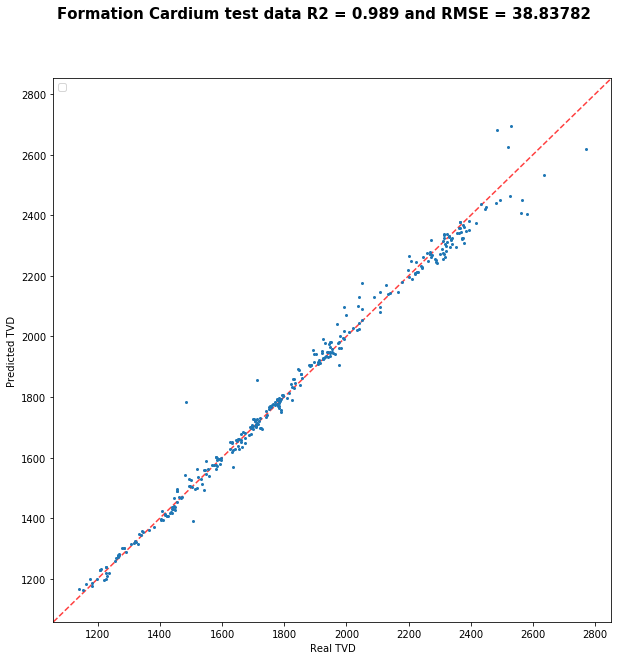

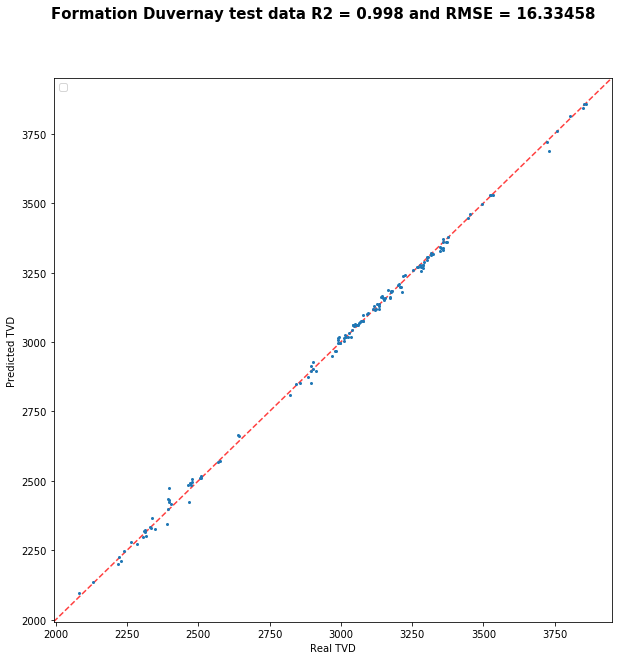

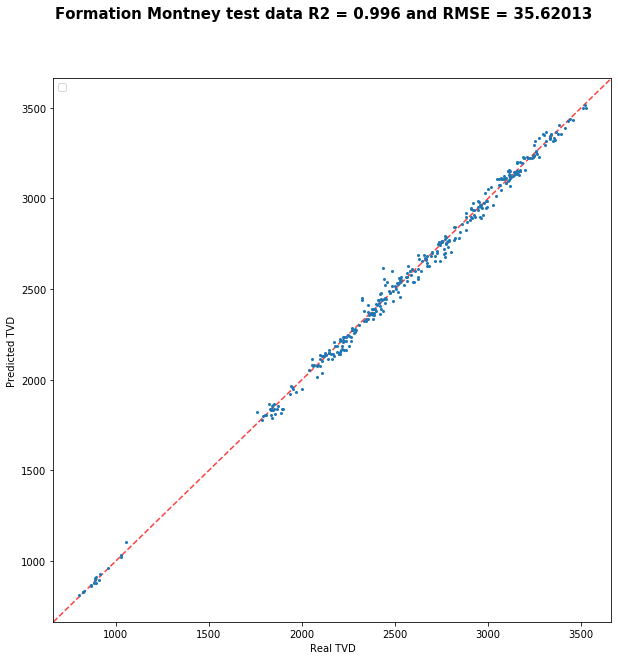

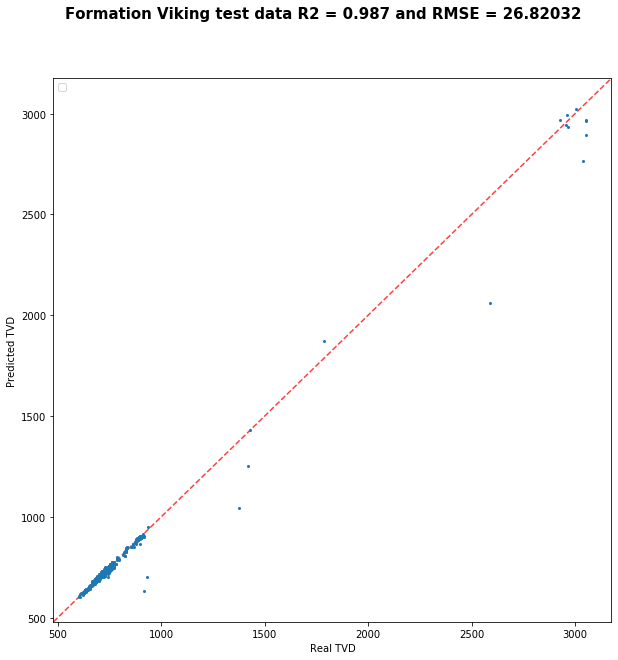

In [376]:
to_drop = ['CurrentOperatorParent', 'Surf_UTMX', 'Surf_UTMY', 'BH_Latitude', 'BH_Longitude', 
           'BH_UTMX', 'BH_UTMY', 'Distance', 'TVD']

for i in np.sort(df_train.Formation.unique()):
    df_split=df_train[df_train.Formation.values==i].copy()
    target = df_split['TVD']
    attributes = df_split.drop(CategoricalColumns, axis=1).drop(to_drop, axis = 1)
    attributes, target = shuffle(attributes, target, random_state=random_seed)
    
    X_train, X_test, Y_train, Y_test = train_test_split(attributes,target,test_size=0.3,random_state=random_seed)
    X_train = scalerX.fit_transform(X_train); Y_train = Y_train.to_numpy().reshape(-1,1)
    X_test = scalerX.transform(X_test);       Y_test = Y_test.to_numpy().reshape(-1,1)
    
    #kfold = KFold(n_splits=5, shuffle=True, random_state=random_seed)
    kfold = 5
    
    param_grid = {
                  'C': np.logspace(1, 5, num=5),
                  'epsilon' :  np.logspace(-4, 1, num=3),
                  'gamma' :    np.logspace(-4, 1, num=3)
                 }
    model = GridSearchCV(estimator=SVR(kernel='rbf'), param_grid=param_grid,
                         scoring=['neg_mean_squared_error', 'r2'], refit='neg_mean_squared_error', cv=kfold)

    print('\n%s Formation\n' % i)
    
    model.fit(X_train,Y_train.ravel())
    
    # summarize results
    print("Best: %f using %s" % (np.sqrt(-model.best_score_), model.best_params_))
    results = DataFrame({'rank': model.cv_results_['rank_test_r2'], 'R² means': model.cv_results_['mean_test_r2'],
                         'RMSE means': np.sqrt(-model.cv_results_['mean_test_neg_mean_squared_error']), 
                         'params': model.cv_results_['params'] })
    
    results.set_index('rank', inplace=True)#
    results.sort_index(inplace=True)
    print(results)
        
    Y_pred = model.predict(X_test)
    
    #test the accuracy
    mse = mean_squared_error(Y_test, Y_pred)
    rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))
    r2 = r2_score(Y_test, Y_pred)
    print("\nVariance R² score: %.2f" % r2, "Mean squared error: %.2f" % mse, "Root Mean squared error: %.2f" % rmse)
    plot_result(Y_test, Y_pred, r2, rmse, i)

*Test Prediction combining RegressionKriging and SVR*

In [391]:
#to_drop = ['CurrentOperatorParent', 'BH_Latitude', 'BH_Longitude', 'BH_UTMX', 'BH_UTMY', 'Distance', 'TVD']

for i in np.sort(df_train.Formation.unique()):
    if i != 'Cardium':   #'Cardium' not in i and "Vertical" not in i:#
        df_split=df_train[df_train.Formation.values==i].copy()
        Y_train = df_split['TVD']
        X_train = df_split.drop(CategoricalColumns, axis=1)
        XY_train = X_train[['Surf_UTMX', 'Surf_UTMY']].to_numpy()
        YZ_train = X_train[['Surf_Latitude','Surf_Longitude','TotalDepth','Diff_Elevation',
                            'GroundElevation', 'KBElevation']].to_numpy()
                
        if str(i).startswith('Duvernay'):#i == 'Duvernay':
            param = {'C': 100000, 'epsilon': 0.0001, 'gamma': 0.03162277660168379}
        elif str(i).startswith('Montney'):#i == 'Montney':
            param = {'C': 100000, 'epsilon': 0.03162277660168379, 'gamma': 0.03162277660168379}
        elif str(i).startswith('Viking'):#i == 'Viking ':
            param = {'C': 100000, 'epsilon': 0.0001, 'gamma': 0.0001}
            
        print('\n%s Formation\n' % i)
            
        Reg = RegressionKriging(regression_model = SVR(C=param['C'], kernel='rbf',epsilon=param['epsilon'], 
                                                       gamma=param['gamma']), 
                                variogram_model= 'spherical')
        
        Reg.fit(scalerX.fit_transform(YZ_train), XY_train, Y_train)
        
        df_split=df_blind[df_blind.Formation.values==i].copy()
        X_blind = df_split.drop(CategoricalColumns,axis=1)  
        XY_blind = X_blind[['Surf_UTMX', 'Surf_UTMY']].to_numpy()
        YZ_blind = X_blind[['Surf_Latitude','Surf_Longitude','TotalDepth','Diff_Elevation', 
                            'GroundElevation', 'KBElevation']].to_numpy()
        df_blind['TVD'][df_blind.Formation.values==i] = Reg.predict(scalerX.transform(YZ_blind),XY_blind)


Duvernay Formation

Finished learning regression model
Finished kriging residuals

Montney Formation

Finished learning regression model
Finished kriging residuals

Viking Formation

Finished learning regression model
Finished kriging residuals


In [379]:
df_blind['TVD'].to_csv('./Submission.csv')

### 4. Summary:

- We find some highly-correlated input features to reduce prediction errors and may cause overfitting. 

- Combining Regression Kriging and Support vector model yield good results.

- Removing wells with TVD less than KB elevation helps to better reduce prediction errors.

- Different machine learning models for different formation improve the performance of our models.